# DSI Project 3: Reddit Post Classifier

### Problem Statement

**Reddit** is a website comprising user-generated content — including media and text-based posts — and discussions in a bulletin board system. The name "Reddit" is a play-on-words with the phrase "read it", i.e., "I read it on Reddit." As of 2018, there are approximately 330 million Reddit users, called "redditors". The site's content is divided into categories or communities known on-site as "subreddits", of which there are more than 138,000 active communities.

Given the nature of Reddit as a discussion forum, many patients and caretakers of patients with mental health conditions go to Reddit to get information and support in managing the condition, or simply sharing their personal experience and emotions in face of their condition.

This project focus on helping mental health organisations to better manage its patient support service when handling messages coming in via social media messagers or chatbots.

The two conditions chosen, **depression** and **bipolar disorder**, have some similarities in symptoms, but have their unique [differences](https://www.webmd.com/bipolar-disorder/bipolar-vs-depression) as well. It is also important to differentiate the conditions to direct to the right specialists for appropriate care and treatment.

* Extracting posts from 2 subreddits using Reddit API: [r/depression](https://www.reddit.com/r/depression/) and [r/bipolar](https://www.reddit.com/r/bipolar/)
* Use **Natural Language Processing (NLP)** to build bag of words for each condition
* Use **Classification Models** to build **Text Classifer** to help classify the text messages from social media/ messagers/ chatbots, so that they can be channel to the right team for follow up.

This can be used to help mental health organisations' patient support units improve patients' experience and productivity.

## 1. Webscrapping

In [1]:
# import libraries
import pandas as pd
import numpy as np
import requests
import time
import random
from pathlib import Path
import regex as re

from nltk.corpus import wordnet, stopwords
import nltk
#bltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-muted')
%matplotlib inline

Let's proceed to scrap the data.

In [2]:
# check if data file exists
data = Path('./raw_reddit_data.csv')

# if data file exists, read the file
if data.is_file():
    df = pd.read_csv('./raw_reddit_data.csv')

# else, read data from reddit
else: 
    posts = []
    for subreddit in ['depression', 'bipolar']:
        after = None
        
        for a in range(40):
            # update url
            if after == None:
                current_url = 'https://www.reddit.com/r/'+subreddit+'.json'
            else:
                current_url = 'https://www.reddit.com/r/'+subreddit+'.json'+'?after='+ after
        
            # get data from reddit API
            res = requests.get(current_url, headers={'User-agent': 'esther bot 1.0'})
            if res.status_code != 200:
                print('Status error: ', res.status_code)
                break
                
            # get posts
            current_dict = res.json()
            current_posts = [p['data'] for p in current_dict['data']['children']] 
            posts.extend(current_posts)
            after = current_dict['data']['after']
            
            # add posts extracted to csv file
            if a > 0:
                prev_posts_df = pd.read_csv('raw_reddit_data.csv')
                current_posts_df = pd.DataFrame(posts)
                pd.concat([prev_posts_df, current_posts_df], axis=0).to_csv('raw_reddit_data.csv', columns=['subreddit', 'title', 'selftext'], index=False)
            else:
                pd.DataFrame(posts).to_csv('raw_reddit_data.csv', columns=['subreddit', 'title', 'selftext'], index=False)
            
            
            # generate a random sleep duration to be 'polite'
            sleep_duration = random.randint(2, 4)
            time.sleep(sleep_duration)
        

Let's take a look at dataframe.

In [3]:
df.head()

,subreddit,title,selftext
0,depression,Our most-broken and least-understood rules is ...,We understand that most people who reply immed...
1,depression,"Regular check-in post, plus a warning and a re...",Welcome to /r/depression's check-in post - a p...
2,depression,Did your anxiety give you depression or am I j...,My anxiety makes me care too much until I don’...
3,depression,I should have been aborted,No talent. No brains. No looks. Can’t sing. Ca...
4,depression,I want to kill myself and the thoughts are onl...,I am 20F. I’m depressed more than you can imag...


In [4]:
df.shape

(60296, 3)

It is expected that there are duplicates as Reddit tends to do so when scrapping more than 1000 posts.

In [5]:
print(df[df['subreddit'] == 'depression'].shape)
print(df[df['subreddit'] == 'bipolar'].shape)

(39720, 3)
(20576, 3)


Check for numbers of duplicates.

In [6]:
df.duplicated().sum()

58310

Let's drop the duplicates.

In [7]:
df.drop_duplicates(subset=None, keep='first', inplace=True)

In [8]:
df.shape

(1986, 3)

In [9]:
print(df[df['subreddit'] == 'depression'].shape)
print(df[df['subreddit'] == 'bipolar'].shape)

(992, 3)
(994, 3)


Also check for empty posts.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 60295
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1986 non-null   object
 1   title      1986 non-null   object
 2   selftext   1832 non-null   object
dtypes: object(3)
memory usage: 62.1+ KB


In [11]:
df = df.dropna(axis=0)

In [12]:
df.shape

(1832, 3)

In [13]:
print(df[df['subreddit'] == 'depression'].shape)
print(df[df['subreddit'] == 'bipolar'].shape)

(976, 3)
(856, 3)


In [14]:
df.to_csv('reddit_data_no_duplicates.csv')

## 2. Preprocessing & EDA

### 2.1 Initial EDA: Word Cloud

Let's use Word Cloud to do a quick initial visualisation of the most frequently occurring words in the posts for each subreddit, using the **original posts (without preprocessing)**.

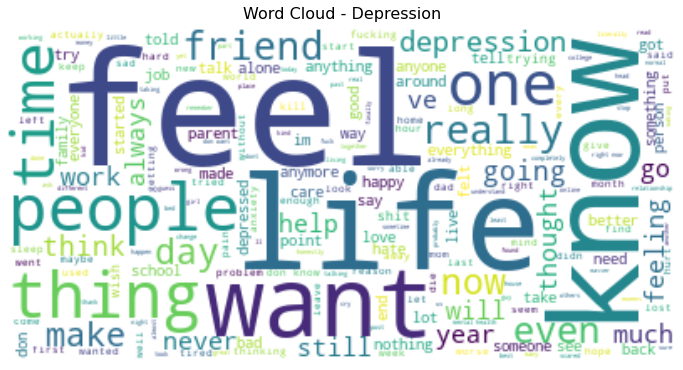

In [15]:
# word cloud for depression
depression_posts = df[df['subreddit'] == 'depression']['selftext']
wordcloud_cancer = WordCloud(background_color="white").generate(' '.join(depression_posts))

plt.figure(figsize = (12,10))
plt.imshow(wordcloud_cancer, interpolation='bilinear')
plt.title('Word Cloud - Depression', fontsize=16, y=1.01)
plt.axis("off");

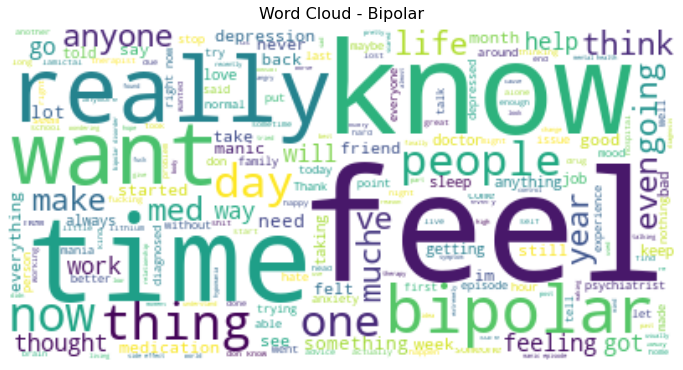

In [16]:
# word cloud for bipolar
bipolar_posts = df[df['subreddit'] == 'bipolar']['selftext']
wordcloud_cancer = WordCloud(background_color="white").generate(' '.join(bipolar_posts))

plt.figure(figsize = (12,10))
plt.imshow(wordcloud_cancer, interpolation='bilinear')
plt.title('Word Cloud - Bipolar', fontsize=16, y=1.01)
plt.axis("off");

As seen from the 2 word clouds, the words in the posts from both subreddits look very similar.

### 2.2 Initial Preprocessing & Frequently Occurring Words

In [17]:
# define a function to convert raw text to a string of meaningful words
def preprocessing(raw_text):
    """
    function to preprocess raw text by removing non-letters, convert words to lower case,
    remove stopwords, and apply Porter Stemmer to stem the words
    input: raw_text in string format
    
    """
    # remove non-letters
    letters_only = re.sub('[^a-zA-Z]', ' ', raw_text)
    
    # convert words to lower case and split each word up
    words = letters_only.lower().split()
    
    # convert stopwords to a set
    stops = set(stopwords.words('english'))
    
    # adding on subreddit topics to stopwords to avoid target leakage 
    stops.update(['depress', 'depressed', 'depression', 'depressing', 'depressant', 'depressants', 
                  'bipolar', 'disorder', 'reddit']) 
    
    # remove stopwords
    meaningful_words = [w for w in words if w not in stops]
        
    # instantiate PorterStemmer
    p_stemmer = PorterStemmer()
    
    # stem words
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]        
   
    # join words back into one string, with a space in between each word
    return(' '.join(meaningful_words))

In [18]:
df['selftext_stem'] = df['selftext'].map(preprocessing)

In [19]:
df.head()

,subreddit,title,selftext,selftext_stem
0,depression,Our most-broken and least-understood rules is ...,We understand that most people who reply immed...,understand peopl repli immedi op invit talk pr...
1,depression,"Regular check-in post, plus a warning and a re...",Welcome to /r/depression's check-in post - a p...,welcom r check post place take moment share go...
2,depression,Did your anxiety give you depression or am I j...,My anxiety makes me care too much until I don’...,anxieti make care much care fluctuat two stop ...
3,depression,I should have been aborted,No talent. No brains. No looks. Can’t sing. Ca...,talent brain look sing studi hate school hate ...
4,depression,I want to kill myself and the thoughts are onl...,I am 20F. I’m depressed more than you can imag...,f imagin newli medic wait kick exhaust keep im...


In [20]:
# checking how a post looks like BEFORE preprocessing
df.loc[2]['selftext']

'My anxiety makes me care too much until I don’t care at all and I fluctuate between the two. How can I stop this? Depression is quickly starting to win the battle against me😶'

In [21]:
# and AFTER preprocessing
df.loc[2]['selftext_stem']

'anxieti make care much care fluctuat two stop quickli start win battl'

Let's vectorize the posts from each subreddit and further check on the frequently occurring words, so that they can included in stopwords.

In [22]:
df_depression = df[df['subreddit'] == 'depression']

In [23]:
# instantiate countvectorizer
cvec_dp = CountVectorizer()
# fit on depression posts
depression_features = cvec_dp.fit_transform(df_depression['selftext_stem'])
# convert to dataframe
depression_features_df = pd.DataFrame(depression_features.toarray(), columns = cvec_dp.get_feature_names())
# get the most frequently occuring words for depression
top_depression_words = depression_features_df.sum().sort_values().tail(20)

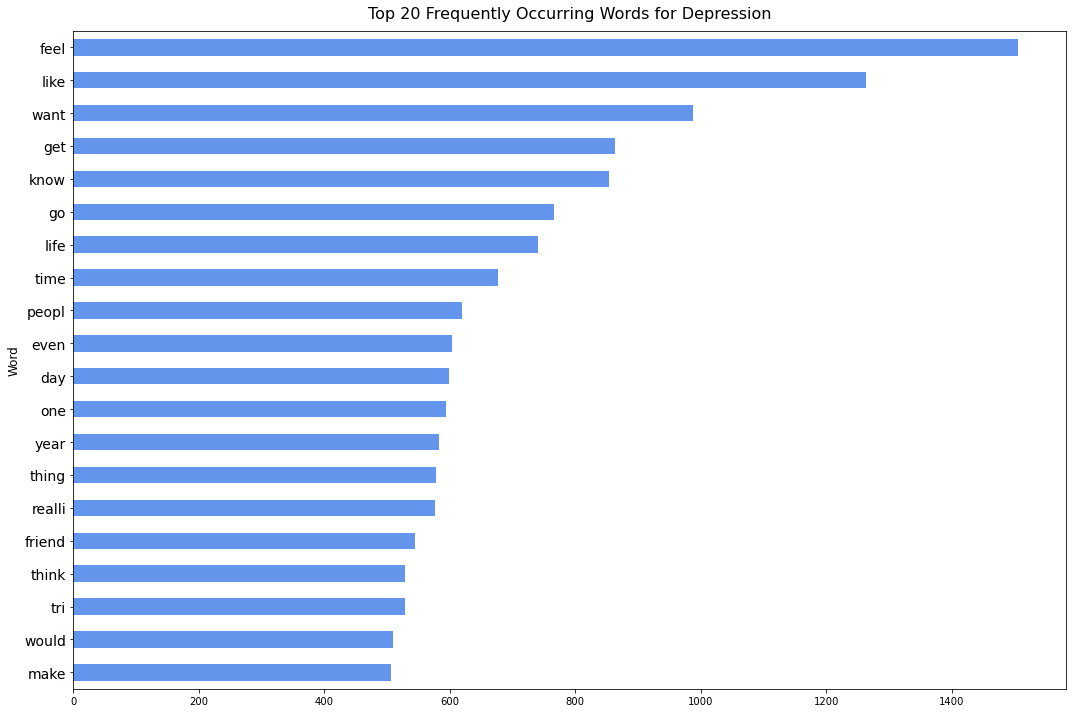

In [24]:
# plot most frequently occuring words related to depression
top_depression_words.plot(x='word', y='exp_coef', kind='barh', figsize=(15, 10), legend=None, color='cornflowerblue')
plt.title("Top 20 Frequently Occurring Words for Depression", size=16, y=1.01)
plt.ylabel('Word', size=12)
plt.yticks(size=14)
plt.tight_layout();

In [25]:
df_bipolar = df[df['subreddit'] == 'bipolar']

In [26]:
# instantiate countvectorizer
cvec_bp = CountVectorizer()
# fit on bipolar posts
bipolar_features = cvec_bp.fit_transform(df_bipolar['selftext_stem'])
# convert to dataframe
bipolar_features_df = pd.DataFrame(bipolar_features.toarray(), columns = cvec_bp.get_feature_names())
# get the most frequently occurring words for bipolar
top_bipolar_words = bipolar_features_df.sum().sort_values().tail(20)

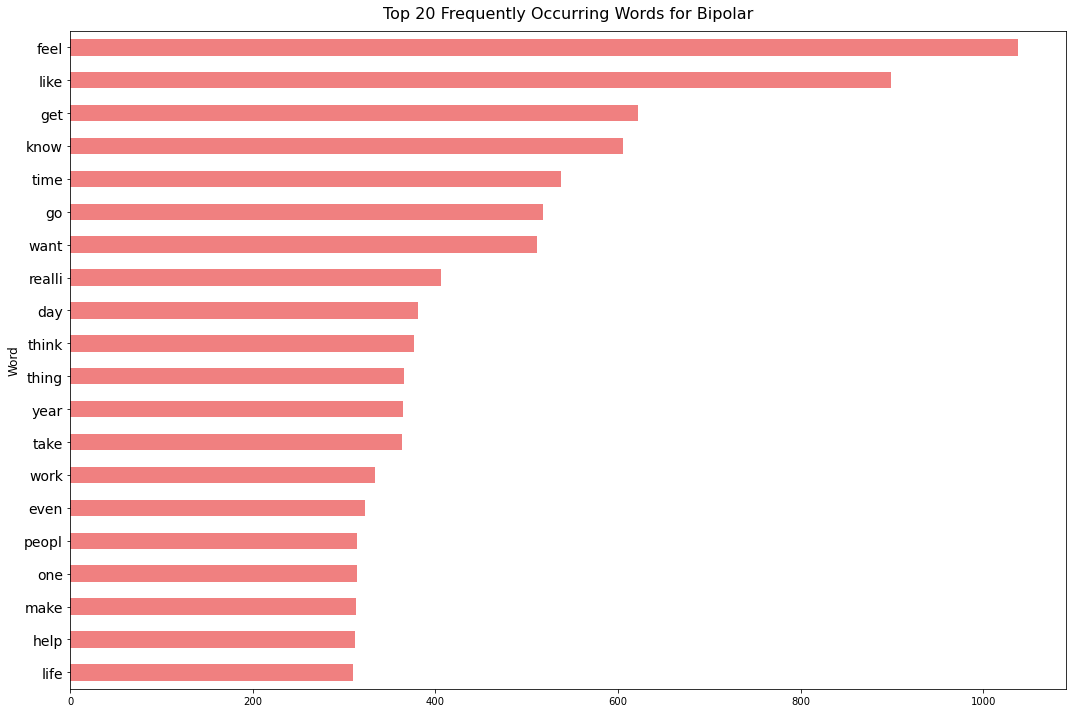

In [27]:
# plot most frequently occuring words related to bipolar
top_bipolar_words.plot(x='word', y='exp_coef', kind='barh', figsize=(15, 10), legend=None, color='lightcoral')
plt.title("Top 20 Frequently Occurring Words for Bipolar", size=16, y=1.01)
plt.ylabel('Word', size=12)
plt.yticks(size=14)
plt.tight_layout();

From the initial round of EDA, the following words are added to the stopwords to improve model accuracy:

'feel', 'feeling', 'like', 'want', 'get', 'know', 'go', 'going', 'time', 'people', 'even', 'day', 'year', 'one', 'thing', 'really', 'think', 'thought','make', 'life', 'would', 'work', 'help', 'much', 'start', 'back'

In [28]:
# define a function to convert raw text to a string of meaningful words
def preprocessing_final(raw_text):
    """
    function to preprocess raw text by removing non-letters, convert words to lower case,
    remove stopwords, and apply Porter Stemmer to stem the words
    input: raw_text in string format
    
    """
    # remove non-letters
    letters_only = re.sub('[^a-zA-Z]', ' ', raw_text)
    
    # convert words to lower case and split each word up
    words = letters_only.lower().split()
    
    # convert stopwords to a set
    stops = set(stopwords.words('english'))
    
    # adding on subreddit topics to stopwords to avoid target leakage 
    stops.update(['depress', 'depressed', 'depression', 'depressing', 'depressant', 'depressants', 
                  'bipolar', 'disorder', 'reddit']) 
    
    # additional stopwords added after initial round of EDA 
    # by checking top frequently occuring words in both subreddit
    stops.update(['feel', 'feeling', 'like', 'want', 'get', 'know', 'go', 'going', 'time', 'people', 
                  'even', 'day', 'year', 'one', 'thing', 'really', 'think', 'thought','make', 'life',  
                  'would', 'work', 'help', 'much', 'start', 'back']) 
    
    # remove stopwords
    meaningful_words = [w for w in words if w not in stops]
        
    # instantiate PorterStemmer
    p_stemmer = PorterStemmer()
    
    # stem words
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]        
   
    # join words back into one string, with a space in between each word
    return(' '.join(meaningful_words))

In [29]:
df['selftext_stem'] = df['selftext'].map(preprocessing_final)

## 3. Classification Models

In [30]:
df['subreddit_depression'] = df['subreddit'].apply(lambda x: 1 if x =='depression' else 0)

In [31]:
# set up X and y
X = df['selftext_stem']
y = df['subreddit_depression']

In [32]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [33]:
y_test.value_counts(normalize=True)

1    0.532751
0    0.467249
Name: subreddit_depression, dtype: float64

Baseline accuracy is 0.532751.

### Model 1a: Logistic Regression (Features extracted by CountVectorizer)

In [34]:
pipe_lr_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver='lbfgs'))
])

In [35]:
# based on default parameters
cross_val_score(pipe_lr_cvec, X_train, y_train, cv=5).mean()

0.7627259455872595

In [36]:
pipe_lr_cvec.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('lr',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'cvec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='conten

In [37]:
pipe_lr_cvec_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [0.9, 0.95, 1.0],
    'cvec__ngram_range': [(1, 1), (1,2)],
    'lr__C': [0.1, 1.0, 10],
    'lr__max_iter': [100, 200]
}

In [38]:
gs_lr_cvec = GridSearchCV(pipe_lr_cvec, param_grid = pipe_lr_cvec_params, cv=5)

In [39]:
gs_lr_cvec.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [40]:
# train accuracy
gs_lr_cvec.best_score_

0.781648307896483

In [41]:
gs_lr_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'lr__C': 0.1,
 'lr__max_iter': 100}

In [42]:
lr_cvec_gs_model = gs_lr_cvec.best_estimator_

In [43]:
# test accuracy
lr_cvec_gs_model_score = lr_cvec_gs_model.score(X_test, y_test)
lr_cvec_gs_model_score

0.7860262008733624

In [44]:
lr_cvec_gs_model_y_preds = lr_cvec_gs_model.predict(X_test)

In [45]:
def model_evaluation(model_name, model, X_test, y_test, y_pred):
    """function to compute various classification model
    evaluation metrics"""
    print(f"Model           : {model_name}")
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"True Negatives  : {tn}")
    print(f"False Positives : {fp}")
    print(f"False Negatives : {fn}")
    print(f"True Positives  : {tp}")
    accuracy = model.score(X_test, y_test)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    
    print(f"Accuracy        : {accuracy:.4f}")
    print(f"Sensitivity     : {sensitivity:.4f}")
    print(f"Specificity     : {specificity:.4f}")
    print(f"Precision       : {precision:.4f}" % precision)
    
    F1_score = 2*((precision*sensitivity)/(precision+sensitivity))
    print(f"F1 score        : {F1_score:.4f}")

In [46]:
model_evaluation('Logistic Regression with CountVectorizer', lr_cvec_gs_model,
                 X_test, y_test, lr_cvec_gs_model_y_preds)

Model           : Logistic Regression with CountVectorizer
True Negatives  : 158
False Positives : 56
False Negatives : 42
True Positives  : 202
Accuracy        : 0.7860
Sensitivity     : 0.8279
Specificity     : 0.7383
Precision       : 0.7829
F1 score        : 0.8048


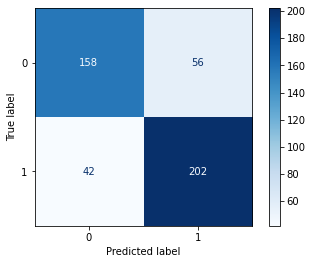

In [47]:
plot_confusion_matrix(lr_cvec_gs_model, X_test, y_test, cmap='Blues', values_format='d');

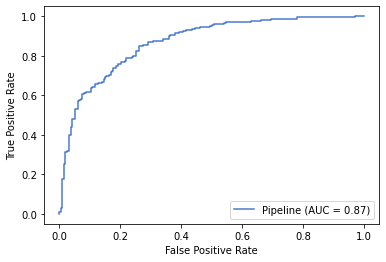

In [48]:
plot_roc_curve(lr_cvec_gs_model, X_test, y_test);

### Model 1b: Logistic Regression (Features extracted by TfidfVectorizer)

In [49]:
pipe_lr_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver='lbfgs'))
])

In [50]:
# based on default parameters
cross_val_score(pipe_lr_tvec, X_train, y_train, cv=5).mean()

0.7911001990710022

In [51]:
pipe_lr_tvec.get_params()

{'memory': None,
 'steps': [('tvec',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('lr',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'tvec': TfidfVectorizer(analyzer='word', binary=False, decode_error='str

In [52]:
pipe_lr_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000],
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.9, 0.95, 1.0],
    'tvec__ngram_range': [(1, 1), (1,2)],
    'lr__C': [0.1, 1.0, 10],
    'lr__max_iter': [100, 200]
}

In [53]:
gs_lr_tvec = GridSearchCV(pipe_lr_tvec, param_grid = pipe_lr_tvec_params, cv=5)

In [54]:
gs_lr_tvec.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [55]:
# train accuracy
gs_lr_tvec.best_score_

0.7954638354346384

In [56]:
gs_lr_tvec.best_params_

{'lr__C': 10,
 'lr__max_iter': 100,
 'tvec__max_df': 0.9,
 'tvec__max_features': 4000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [57]:
lr_tvec_gs_model = gs_lr_tvec.best_estimator_

In [58]:
# test accuracy
lr_tvec_gs_model_score = lr_tvec_gs_model.score(X_test, y_test)
lr_tvec_gs_model_score

0.8122270742358079

In [59]:
lr_tvec_gs_model_y_preds = lr_tvec_gs_model.predict(X_test)

In [60]:
model_evaluation('Logistic Regression with TfidfVectorizer', lr_tvec_gs_model,
                 X_test, y_test, lr_tvec_gs_model_y_preds)

Model           : Logistic Regression with TfidfVectorizer
True Negatives  : 172
False Positives : 42
False Negatives : 44
True Positives  : 200
Accuracy        : 0.8122
Sensitivity     : 0.8197
Specificity     : 0.8037
Precision       : 0.8264
F1 score        : 0.8230


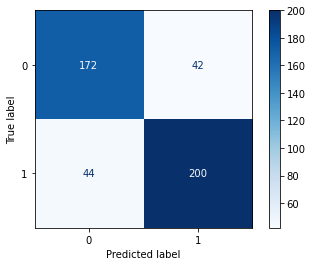

In [61]:
plot_confusion_matrix(lr_tvec_gs_model, X_test, y_test, cmap='Blues', values_format='d');

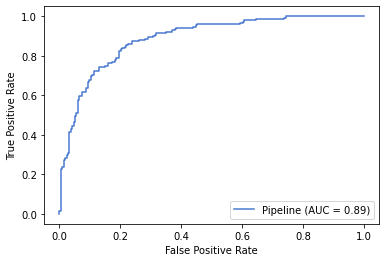

In [62]:
plot_roc_curve(lr_tvec_gs_model, X_test, y_test);

### Model 2a: MultinomialNB (Features extracted by CountVectorizer)

In [63]:
pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [64]:
# based on default parameters
cross_val_score(pipe_nb_cvec, X_train, y_train, cv=5).mean()

0.7801831453218314

In [65]:
pipe_nb_cvec.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'verbose': False,
 'cvec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 'nb': M

In [66]:
pipe_nb_cvec_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [0.9, 0.95, 1.0],
    'cvec__ngram_range': [(1, 1), (1,2)],
    'nb__alpha': [1.0, 1e-1, 1e-2]
}

In [67]:
gs_nb_cvec = GridSearchCV(pipe_nb_cvec, param_grid = pipe_nb_cvec_params, cv=5)

In [68]:
gs_nb_cvec.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [69]:
# train accuracy
gs_nb_cvec.best_score_

0.7889343065693432

In [70]:
gs_nb_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'nb__alpha': 0.1}

In [71]:
nb_cvec_gs_model = gs_nb_cvec.best_estimator_

In [72]:
# test accuracy
nb_cvec_gs_model_score = nb_cvec_gs_model.score(X_test, y_test)
nb_cvec_gs_model_score

0.8056768558951966

In [73]:
nb_cvec_gs_model_y_preds = nb_cvec_gs_model.predict(X_test)

In [74]:
model_evaluation('MultinomialNB with CountVectorizer', nb_cvec_gs_model,
                 X_test, y_test, nb_cvec_gs_model_y_preds)

Model           : MultinomialNB with CountVectorizer
True Negatives  : 168
False Positives : 46
False Negatives : 43
True Positives  : 201
Accuracy        : 0.8057
Sensitivity     : 0.8238
Specificity     : 0.7850
Precision       : 0.8138
F1 score        : 0.8187


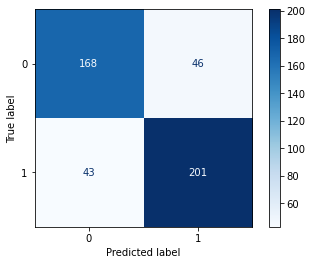

In [75]:
plot_confusion_matrix(nb_cvec_gs_model, X_test, y_test, cmap='Blues', values_format='d');

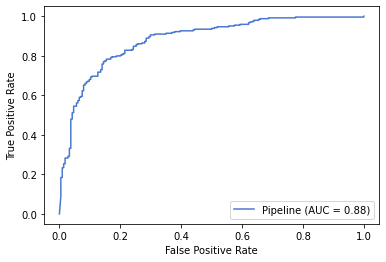

In [76]:
plot_roc_curve(nb_cvec_gs_model, X_test, y_test);

### Model 2b: MultinomialNB (Features extracted by TfidfVectorizer)

In [77]:
pipe_nb_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [78]:
# based on default parameters
cross_val_score(pipe_nb_tvec, X_train, y_train, cv=5).mean()

0.7554505640345056

In [79]:
pipe_nb_tvec.get_params()

{'memory': None,
 'steps': [('tvec',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'verbose': False,
 'tvec': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, s

In [80]:
pipe_nb_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000],
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.9, 0.95, 1.0],
    'tvec__ngram_range': [(1, 1), (1,2)],
    'nb__alpha': [1.0, 1e-1, 1e-2]
}

In [81]:
gs_nb_tvec = GridSearchCV(pipe_nb_tvec, param_grid = pipe_nb_tvec_params, cv=5)

In [82]:
gs_nb_tvec.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [83]:
# train accuracy
gs_nb_tvec.best_score_

0.7925680159256803

In [84]:
gs_nb_tvec.best_params_

{'nb__alpha': 0.1,
 'tvec__max_df': 0.9,
 'tvec__max_features': 3000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [85]:
nb_tvec_gs_model = gs_nb_tvec.best_estimator_

In [86]:
# test accuracy
nb_tvec_gs_model_score = nb_tvec_gs_model.score(X_test, y_test)
nb_tvec_gs_model_score

0.8144104803493449

In [87]:
nb_tvec_gs_model_y_preds = nb_tvec_gs_model.predict(X_test)

In [88]:
model_evaluation('MultinomialNB with TfidVectorizer', nb_tvec_gs_model,
                 X_test, y_test, nb_tvec_gs_model_y_preds)

Model           : MultinomialNB with TfidVectorizer
True Negatives  : 165
False Positives : 49
False Negatives : 36
True Positives  : 208
Accuracy        : 0.8144
Sensitivity     : 0.8525
Specificity     : 0.7710
Precision       : 0.8093
F1 score        : 0.8303


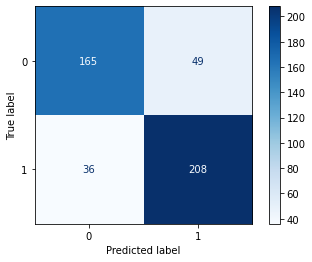

In [89]:
plot_confusion_matrix(nb_tvec_gs_model, X_test, y_test, cmap='Blues', values_format='d');

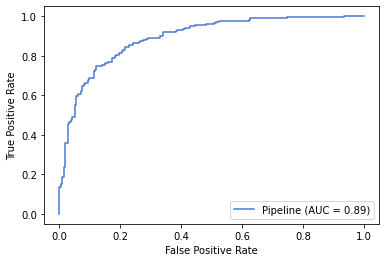

In [90]:
plot_roc_curve(nb_tvec_gs_model, X_test, y_test);

### Model 3a: Support Vector Machine (Features extracted by CountVectorizer)

In [91]:
pipe_svm_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('svm', SVC())
])

In [92]:
# based on default parameters
cross_val_score(pipe_svm_cvec, X_train, y_train, cv=5).mean()

0.7583649635036496

In [93]:
pipe_svm_cvec.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('svm',
   SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
       decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
       max_iter=-1, probability=False, random_state=None, shrinking=True,
       tol=0.001, verbose=False))],
 'verbose': False,
 'cvec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,


In [94]:
pipe_svm_cvec_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [0.9, 0.95, 1.0],
    'cvec__ngram_range': [(1, 1), (1,2)],
    'svm__kernel': ['rbf', 'poly'],
    'svm__C': [0.1, 1.0, 10]
}

In [95]:
gs_svm_cvec = GridSearchCV(pipe_svm_cvec, param_grid = pipe_svm_cvec_params, cv=5)

In [96]:
gs_svm_cvec.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [97]:
# train accuracy
gs_svm_cvec.best_score_

0.7619986728599867

In [98]:
gs_svm_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'svm__C': 10,
 'svm__kernel': 'rbf'}

In [99]:
svm_cvec_gs_model = gs_svm_cvec.best_estimator_

In [100]:
# test accuracy
svm_cvec_gs_model_score = svm_cvec_gs_model.score(X_test, y_test)
svm_cvec_gs_model_score

0.7729257641921398

In [101]:
svm_cvec_gs_model_y_preds = svm_cvec_gs_model.predict(X_test)

In [102]:
model_evaluation('Support Vector Machine with CountVectorizer', svm_cvec_gs_model,
                 X_test, y_test, svm_cvec_gs_model_y_preds)

Model           : Support Vector Machine with CountVectorizer
True Negatives  : 150
False Positives : 64
False Negatives : 40
True Positives  : 204
Accuracy        : 0.7729
Sensitivity     : 0.8361
Specificity     : 0.7009
Precision       : 0.7612
F1 score        : 0.7969


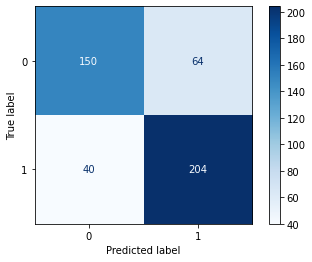

In [103]:
plot_confusion_matrix(svm_cvec_gs_model, X_test, y_test, cmap='Blues', values_format='d');

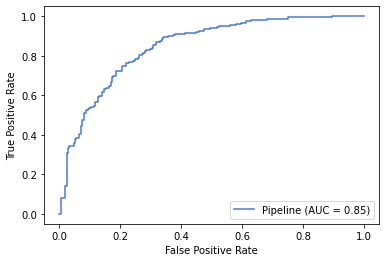

In [104]:
plot_roc_curve(svm_cvec_gs_model, X_test, y_test);

### Model 3b: Support Vector Machine (Features extracted by TfidfVectorizer)

In [105]:
pipe_svm_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm', SVC())
])

In [106]:
# based on default parameters
cross_val_score(pipe_svm_tvec, X_train, y_train, cv=5).mean()

0.7903782349037823

In [107]:
pipe_svm_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000],
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.9, 0.95, 1.0],
    'tvec__ngram_range': [(1, 1), (1,2)],
    'svm__kernel': ['rbf', 'poly'],
    'svm__C': [0.1, 1.0, 10]
}

In [108]:
gs_svm_tvec = GridSearchCV(pipe_svm_tvec, param_grid = pipe_svm_tvec_params, cv=5)

In [109]:
gs_svm_tvec.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [110]:
# train accuracy
gs_svm_tvec.best_score_

0.8027471798274718

In [111]:
gs_svm_tvec.best_params_

{'svm__C': 1.0,
 'svm__kernel': 'rbf',
 'tvec__max_df': 0.9,
 'tvec__max_features': 3000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [112]:
svm_tvec_gs_model = gs_svm_tvec.best_estimator_

In [113]:
# test accuracy
svm_tvec_gs_model_score = svm_tvec_gs_model.score(X_test, y_test)
svm_tvec_gs_model_score

0.8187772925764192

In [114]:
svm_tvec_gs_model_y_preds = svm_tvec_gs_model.predict(X_test)

In [115]:
model_evaluation('Support Vector Machine with TfidfVectorizer', svm_tvec_gs_model,
                 X_test, y_test, svm_tvec_gs_model_y_preds)

Model           : Support Vector Machine with TfidfVectorizer
True Negatives  : 159
False Positives : 55
False Negatives : 28
True Positives  : 216
Accuracy        : 0.8188
Sensitivity     : 0.8852
Specificity     : 0.7430
Precision       : 0.7970
F1 score        : 0.8388


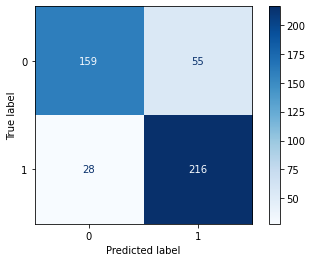

In [116]:
plot_confusion_matrix(svm_tvec_gs_model, X_test, y_test, cmap='Blues', values_format='d');

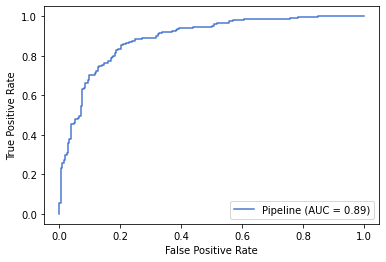

In [117]:
plot_roc_curve(svm_tvec_gs_model, X_test, y_test);

### Model Evaluation Summary:

In [118]:
print('Model Evaluation Summary')
print('\n')
model_evaluation('Logistic Regression with CountVectorizer', lr_cvec_gs_model, X_test, y_test, lr_cvec_gs_model_y_preds)
print('\n')
model_evaluation('Logistic Regression with TfidfVectorizer', lr_tvec_gs_model, X_test, y_test, lr_tvec_gs_model_y_preds)
print('\n')
model_evaluation('MultinomialNB with CountVectorizer', nb_cvec_gs_model, X_test, y_test, nb_cvec_gs_model_y_preds)
print('\n')
model_evaluation('MultinomialNB with TfidVectorizer', nb_tvec_gs_model, X_test, y_test, nb_tvec_gs_model_y_preds)
print('\n')
model_evaluation('Support Vector Machine with CountVectorizer', svm_cvec_gs_model, X_test, y_test, svm_cvec_gs_model_y_preds)
print('\n')
model_evaluation('Support Vector Machine with TfidfVectorizer', svm_tvec_gs_model, X_test, y_test, svm_tvec_gs_model_y_preds)
print('\n')

Model Evaluation Summary


Model           : Logistic Regression with CountVectorizer
True Negatives  : 158
False Positives : 56
False Negatives : 42
True Positives  : 202
Accuracy        : 0.7860
Sensitivity     : 0.8279
Specificity     : 0.7383
Precision       : 0.7829
F1 score        : 0.8048


Model           : Logistic Regression with TfidfVectorizer
True Negatives  : 172
False Positives : 42
False Negatives : 44
True Positives  : 200
Accuracy        : 0.8122
Sensitivity     : 0.8197
Specificity     : 0.8037
Precision       : 0.8264
F1 score        : 0.8230


Model           : MultinomialNB with CountVectorizer
True Negatives  : 168
False Positives : 46
False Negatives : 43
True Positives  : 201
Accuracy        : 0.8057
Sensitivity     : 0.8238
Specificity     : 0.7850
Precision       : 0.8138
F1 score        : 0.8187


Model           : MultinomialNB with TfidVectorizer
True Negatives  : 165
False Positives : 49
False Negatives : 36
True Positives  : 208
Accuracy        : 0.8144


Among the various classifier models, the ones with features extracted by TfidfVectorizers seem to be performing better.

**Support Vector Machine with TfidfVectorizer** performs the best, with an accuracy of 81.88% and F1 score of 83.88%. 

However, it is noted that: 

* the **model perform much better in terms of sensitivity** (i.e. predicting actual positives/ depression cases correctly) of 88.52% , and 
* perform **not so well in terms of specificity** (predicting the actual negatives/ bipolar cases correctly) of 74.3%.

A similar issue is noted for MultinomialNB model with TfidfVectorizer. While accuracy is 81.44% and F1 score is 83.03%, it has high sensitivity (85.25%) and low specificity (77.10%).

**Logistic Regression with TfidfVectorizer** may be a more balanced classification model. With a fairly comparable accuracy of 81.22% and F1 score of 82.3%, its performance in terms of sensitivity and specificity is more balanced (81.97% vs. 80.37%)

## 4. Review on Selected Model - Logistic Regression with TfidfVectorizer

In [119]:
# Create a dataframe for only the test data
results_df = df.loc[y_test.index, :] 

# Insert a column for predictions from best model
results_df['pred'] = lr_tvec_gs_model_y_preds

In [120]:
results_df.head()

,subreddit,title,selftext,selftext_stem,subreddit_depression,pred
10067,bipolar,Quetiapine and fluoxetine,Has anyone been on a combination of quetiapine...,anyon combin quetiapin fluoxetin quetiapin cou...,0,0
31362,bipolar,Anyone have any good coping tips for depersona...,I’m a a wee bit desperate but it’s cool ya kno...,wee bit desper cool ya alway gonna okay end,0,1
664,depression,my life is over,cant get friends. cant get a partner. cant los...,cant friend cant partner cant lose cant ride s...,1,1
11324,bipolar,Random days where you wake up at 5:30 am after...,I've also had difficulty falling asleep due to...,also difficulti fall asleep due lot thought night,0,0
58299,bipolar,Struggling with changing Meds and the Diagnosis,"Hi, so this is my first post on reddit and the...",hi first post first talk ill internet bit long...,0,0


### 4.1 Misclassification - False Positives

Let's first explore the **False Positives**, in which the model misclassify bipolar as depression:

In [121]:
# False positives - Model incorrectly classify bipolar as depression
pd.set_option('display.max_colwidth', None)
results_df[(results_df['subreddit_depression']==0) & (results_df['pred']==1)]

,subreddit,title,selftext,selftext_stem,subreddit_depression,pred
31362,bipolar,Anyone have any good coping tips for depersonalization?,"I’m a a wee bit desperate but it’s cool ya know, I’m always gonna be okay in the end.",wee bit desper cool ya alway gonna okay end,0,1
2051,bipolar,i do not exist and you cannot convince me i do,i have somehow slipped out of the realm of physical existence. i have not had human contact in 15 hours and i have not slept in 3 days. the only contact i have had has been with the voices. it’s kinda comforting honestly. no one has made any attempt to contact me and i think that’s because they can’t. i don’t exist and you cannot convince me i do.,somehow slip realm physic exist human contact hour slept day contact voic kinda comfort honestli made attempt contact exist cannot convinc,0,1
6474,bipolar,I Feel Really Bad,"A year ago, I had someone I had grown very close to over the course of several months reveal that they were lying to me about being friends. That sent me into a downward spiral where I became bulimic, manic for two months then numbed out by medication the next four months, tried to kill my self twice, and had an accidental drug overdose brought on by academic stress. It was probably the worst 6 months of my life. \n\nToday, I learned that my roommate from that time also lied to me about being friends for the entire semester we lived together. She had ghosted me over the summer, and I happened to run into her in my dorm and made her explain. She said I was toxic to be around. It’s just hurt me so bad. I’ve spent the night trying to watch movies and shows to distract myself, but I just feel so sad. I know I have people I can talk to, but I don’t know how. Some of my friends have tried to reassure me that I’m not toxic, but what if I am and everyone’s just lying to me to not hurt my feelings? \n\nMy first thought when I feel bad is that maybe I should kill myself. Maybe this world is better off without me being awful in it. I don’t want to hurt myself. I’m afraid that this is going to send me into another downward spiral. I can’t do that again. It’s just so miserable. Nothing makes it better. \n\nI really needed somewhere to let this out because I hate worrying people I know. I tried writing about it, but that’s only making me sadder. I need to sleep. I need to reset. Maybe I’ll feel better tomorrow.",ago someon grown close cours sever month reveal lie friend sent downward spiral becam bulim manic two month numb medic next four month tri kill self twice accident drug overdos brought academ stress probabl worst month today learn roommat also lie friend entir semest live togeth ghost summer happen run dorm made explain said toxic around hurt bad spent night tri watch movi show distract sad talk friend tri reassur toxic everyon lie hurt feel first bad mayb kill mayb world better without aw hurt afraid send anoth downward spiral miser noth make better need somewher let hate worri tri write make sadder need sleep need reset mayb better tomorrow,0,1
26653,bipolar,Why am I like this,"I (20m) feel very romantically lonely but don't know where/how to meet people my age. Everyone said to use dating apps but from my experience, I only use them when I'm manic and narcissistic. When that happens, my standards become impossibly high (not necessarily just appearance), I never swipe right on anyone, and never even give anyone a chance so I just end up lonely again with no matches. It's like I always find *some* reason to swipe left. I feel bad later because I realize I'm probably a horrible person for it but I just get **extremely** disappointed with the boring people on these apps (I think part of the problem is where I'm located but unfortunately I can't change that anytime soon). I also really hate people that put their political views in their profiles (around here that's 1 out of every 3 profiles) and are very in-your-face about it.\n\nWhen I'm depressed I'm so fucking out of everything that I can't 

Among the False Positives, there are several short/ generic posts which the model is unable to classify correctly:

In [122]:
results_df.loc[36298, 'selftext']

'Except instead of powers I loose my mind...'

In [123]:
results_df.loc[29767, 'selftext']

'And i’m on all of them and they saved my life \n\nIsolating shit man'

There are some posts which also relate more to depression, but was posted on the bipolar subreddits (which may not be real misclassification).

In [124]:
results_df.loc[34628, 'selftext']

'I’m feeling really depressed rn but I can’t tell anyone. I feel like I’m annoying tf out of everyone because I’m always sad and there’s nothing anybody can do or say to make me feel better. I try to smoke and just try to ignore it but now I’m just high af and even more depressed lol'

And in some posts, the person seem to have both bipolar and depression symptoms. For such cases, the binary classification model will not be able to handle properly.

In [125]:
results_df.loc[48696, 'selftext']

'Hi everyone I am new in reddit so I don\'t really now the rules in here sorry in advance for that. I am living in a third world country and unfortunately I have bipolar. Even though most of the time I am depressed I can act like I am "normal" around people. But I am tired of acting like I am good it is exhausting. Recently I lost the meaning of my life and it is like not worth to continue this suffering. Don\'t get me wrong I am not gonna kill myself but I hope I stop existing somehow. Because i am not living I am just here like a chair. I can\'t feel a thing anymore I can\'t tell if I love someone or hate. Love of my life is ignoring me, I have no money, I am in a very crappy country everything seems bad. So why am I bothering to survive? I can\'t answer this question. Like I said I can\'t kill myself I am a coward. I don\'t even know why I am writing this. I know you will say hey man it will be okay etc. But I know nothing gonna be better everything is getting worse with time. I am 

### 4.2 Misclassification - False Negatives

Let's also take a look at the **False Negatives**, in which the model misclassify depression as bipolar:

In [126]:
# False negatives - Model incorrectly classify depression as bipolar
results_df[(results_df['subreddit_depression']==1) & (results_df['pred']==0)]

,subreddit,title,selftext,selftext_stem,subreddit_depression,pred
145,depression,Ketamine for depression,"I have been prescribed ketamine for my depression. I take it every other day for three weeks then something like once every three months afterwards. I don’t know if it helps depression in the long term, but when I take it it is great. It’s like a break from having your thoughts constantly berating you. Unfortunately the effects are short lived. Has anyone else been prescribed this? How did affect your depression. I have tried numerous anti-depressants and they haven’t worked. There’s also research going on right now to see how psilocybin can help with depression, addiction and end of life anxiety. Anyone ever use psychedelics to help them with depression?",prescrib ketamin take everi three week someth everi three month afterward help long term take great break thought constantli berat unfortun effect short live anyon els prescrib affect tri numer anti work also research right see psilocybin addict end anxieti anyon ever use psychedel,1,0
489,depression,This is how depressed I am,I don’t want to waste anyone else’s time talking about what’s happening in my head and my heart. I’m not worthy of your attention or concern. I’m just going to sit here and exist until I can’t bare it any longer.,wast anyon els talk happen head heart worthi attent concern sit exist bare longer,1,0
302,depression,This is a really bad day.,I didn't wanted to talk with my brother because he and me like superheroes.,want talk brother superhero,1,0
146,depression,Worse at night for no reason??,"Everywhere I read says it's due to being alone with your thoughts but no matter where, I'm at work, home, once the sun starts going down I just get a huge wave of depression.nothing to do with my thoughts and I am getting tired of it, anyone else relate?",everywher read say due alon thought matter home sun start huge wave noth thought get tire anyon els relat,1,0
337,depression,"I’m not lazy, I’m just depressed","I hate taking on responsibilities, because I know that sooner or later my depression and anxiety will act up, and I will be unable to take care of whatever I signed up for, which is usually anything people ask of me, because I’m a people pleaser and can’t say no.\n\nI end up with extreme guilt, further escalating my depressive episode, making it even harder to do anything.\n\nPeople probably think I’m lazy, I know I would, and it’s so extremely limiting. I also can’t go around telling everyone that I’m in bed in a dark room struggling with mental illness.\n\nHas anyone else had this problem? And what do you do to avoid it?",hate take respons sooner later anxieti act unabl take care whatev sign usual anyth ask pleaser say end extrem guilt escal depress episod make harder anyth probabl lazi extrem limit also around tell everyon bed dark room struggl mental ill anyon els problem avoid,1,0
456,depression,Online therapist and guides,Hello everyone! Ive been doing some research and came across a few websites that offer therapists that you can just text or hold a conversation online. \n\nThis works great with my busy schedule however My health insurance expired and I have yet to get new insurance due to COVID so the services are pretty costly. \n\nIs there anything out there similar that is affordable?\n\nThanks in advance,hello everyon ive research came across websit offer therapist text hold convers onlin work great busi schedul howev health insur expir yet new insur due covid servic pretti costli anyth similar afford thank advanc,1,0
794,depression,People are talking outside,"I'm in a foreign country. Everyone is laughing, playing, sharing, getting to know each other. I'm just shutting the lights and getting into bed. This is so fucking hard. Did I really have to be this way?",foreign countri everyon laugh play share get shut light get bed fuck hard way,1,0
940,depression,I'm a horrible individual,I'm just a horrible person my life is meaningless and most im

Again, there are some short and generic posts that may not be very telling of the condition the patient has.

In [127]:
results_df.loc[302, 'selftext']

"I didn't wanted to talk with my brother because he and me like superheroes."

And for some posts, even though they appeared in the depression subreddit, the person seems to have bipolar instead. 

In [128]:
results_df.loc[27, 'selftext']

'tl;dr: Always stand up for yourself when you know your medication is not right. I didn\'t, and I almost killed myself.\n\n&amp;#x200B;\n\nIn July, I received a new diagnosis from my second psychiatrist. It turned out I was on the bipolar spectrum, but I was so barely on it that no one noticed. My depressive symptoms were so aggressive, and my hypomania (if you could even call it that) just looked like I was very productive.\n\nThe only way we know for sure is because the new medication I was put on started giving me damaging hypomania symptoms. I told my psychiatrist I randomly was able to stay up for days at a time, and we knew.\n\nMy first psychiatrist didn\'t catch it. In fact, he dismissed it. My therapist at the time almost caught it. After I told her that some days I only need 3 hours of sleep but other days I felt like I needed 12, she suspected I could be bipolar. However, she admitted that she didn\'t feel qualified to diagnose something like that and told me to bring it up w

### 4.3 Most Predictive Words

In [129]:
# Save the vocabulary obtained with CountVectorizer in a dataframe
lr_tvec_coef = pd.DataFrame(lr_tvec_gs_model.named_steps['tvec'].get_feature_names(), columns=['word'])

In [130]:
# Use np.exp() to exponentiate the coefficients
lr_tvec_coef['exp_coef'] = np.exp(lr_tvec_gs_model.named_steps['lr'].coef_[0])

In [131]:
# Top words related to depression (class 1)
depression_lr_tvec = lr_tvec_coef.sort_values(by='exp_coef').tail(10)

# Top words related to bipolar (class 0)
bipolar_lr_tvec = lr_tvec_coef.sort_values(by='exp_coef').head(10)

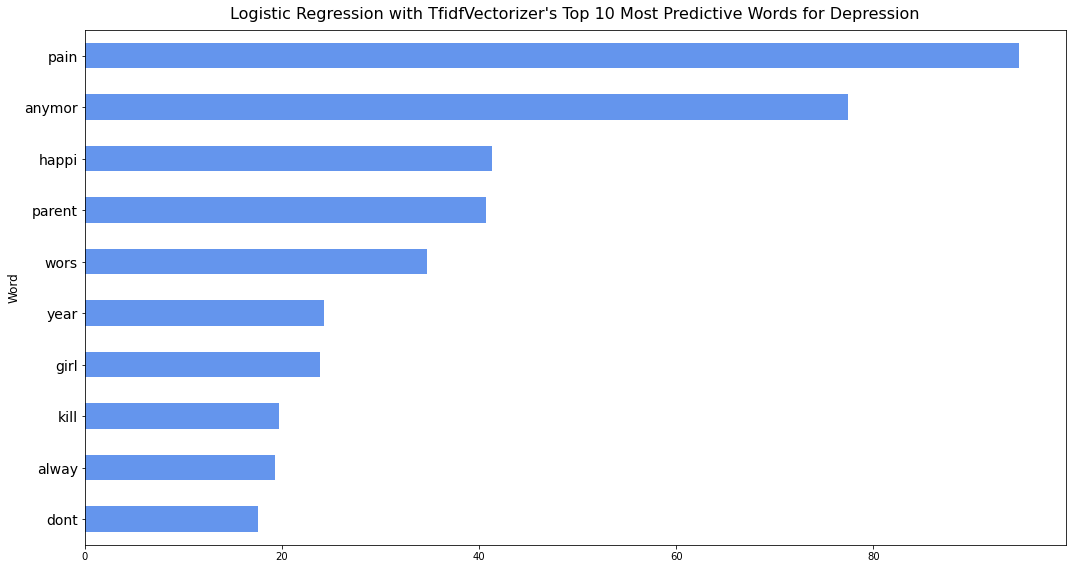

In [134]:
# plot top words related to depression
depression_lr_tvec.plot(x='word', y='exp_coef', kind='barh', figsize=(15, 8), legend=None, color='cornflowerblue')
plt.title("Logistic Regression with TfidfVectorizer's Top 10 Most Predictive Words for Depression", size=16, y=1.01)
plt.ylabel('Word', size=12)
plt.yticks(size=14)
plt.tight_layout();

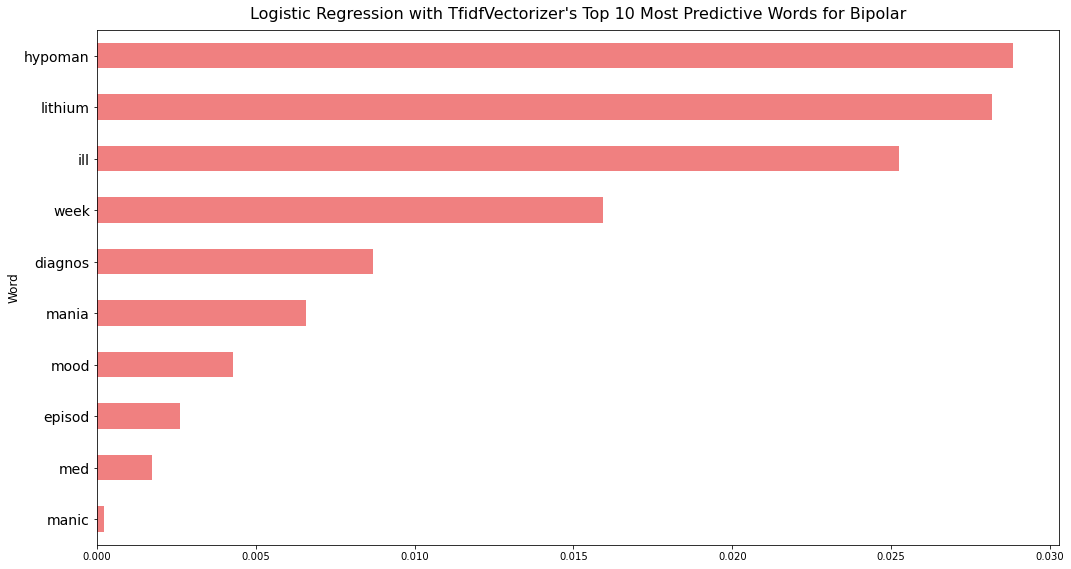

In [135]:
# plot top words related to bipolar
bipolar_lr_tvec.plot(x='word', y='exp_coef', kind='barh', figsize=(15, 8), legend=None, color='lightcoral')
plt.title("Logistic Regression with TfidfVectorizer's Top 10 Most Predictive Words for Bipolar", size=16, y=1.01)
plt.ylabel('Word', size=12)
plt.yticks(size=14)
plt.tight_layout();

## 5. Conclusion & Recommendations

### Conclusion:

Summary of Model Evaluation:

|Model | Accuracy | Sensitivity | Specificity | Precision | F1 Score |
|:---  |:--- |:---  |:--- |:---  |:--- |
| Logistic Regression with CountVectorizer         | 0.7860 | 0.8279 | 0.7383 | 0.7829 | 0.8048 |
| Logistic Regression with TfidfVectorizer         | 0.8122 | 0.8197 | 0.8037 | 0.8264 | 0.8230 |
| MultinomialNB with CountVectorizer               | 0.8057 | 0.8238 | 0.7850 | 0.8138 | 0.8187 |
| MultinomialNB with TfidfVectorizer               | 0.8144 | 0.8525 | 0.7710 | 0.8093 | 0.8303 |
| SVM with CountVectorizer                         | 0.7729 | 0.8361 | 0.7009 | 0.7612 | 0.7969 |
| SVM with TfidfVectorizer                         | 0.8188 | 0.8852 | 0.7430 | 0.7970 | 0.8388 |

Among the various classifier models, **Support Vector Machine with TfidfVectorizer** performs marginally better, with an accuracy of 81.88% and F1 score of 83.88%. 

However, it is noted that: 

* the **model perform much better in terms of sensitivity** of 88.52% (i.e. predicting actual positives/ depression cases correctly), and 
* perform **not so well in terms of specificity** of 74.3% (predicting the actual negatives/ bipolar cases correctly).

A similar issue is noted for MultinomialNB model with TfidfVectorizer. While accuracy is 81.44% and F1 score is 83.03%, it has high sensitivity (85.25%) and low specificity (77.10%).

**Logistic Regression with TfidfVectorizer** may be a more balanced classification model. With a fairly comparable accuracy of 81.22% and F1 score of 82.3%, its performance in terms of sensitivity and specificity is more balanced (81.97% vs. 80.37%)

### Recommendations:

From a patient support point of view, the **Logistic Regression classifier with TfidfVectorizer** should be deployed to ensure that there is a more balanced patient experience for both the depression patients and the bipolar patients. 

If the Support Vector Machine or Multinomial NB with TfidfVectorizer is used, there may be very good patient experience for the depression patients. However, patient experience for bipolar patients may be poor as more bipolar cases misclassified as depression cases due to the lower specificity of the model. It also means that the patient support chanelling efficiency will be lower as missclassified bipolar cases need to be manually channelled back to the depression unit. 

### *Bonus - VADER Sentiment Analysis*

Let's check out the VADER Sentiment Analysis tool to:
* understand the sentiment of depression and bipolar patients in their reddit posts
* see if it is possible to identify posts with positive sentiment to generate similarly positive content for patient support.

In [136]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [137]:
analyzer = SentimentIntensityAnalyzer()

In [138]:
df['compound_score'] = [analyzer.polarity_scores(post)['compound'] for post in df['selftext']]
df['neg_score'] = [analyzer.polarity_scores(post)['neg'] for post in df['selftext']]
df['neu_score'] = [analyzer.polarity_scores(post)['neu'] for post in df['selftext']]
df['pos_score'] = [analyzer.polarity_scores(post)['pos'] for post in df['selftext']]

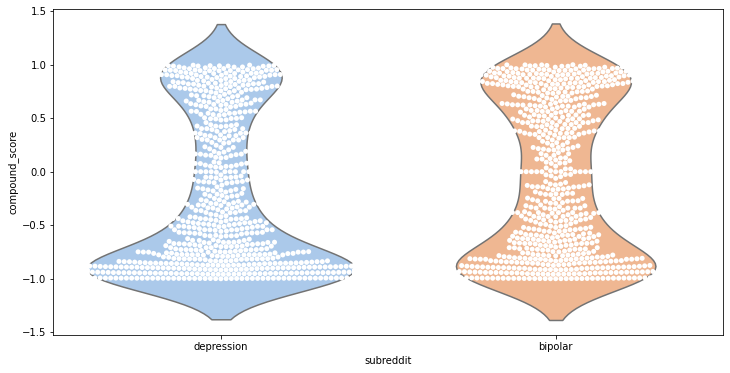

In [139]:
# plotting swarm plot by condition
plt.figure(figsize = (12,6))
sns.violinplot(data=df, x='subreddit', y='compound_score', inner=None, palette='pastel');
sns.swarmplot(data=df, x='subreddit', y='compound_score', color='white', edgecolor='gray', );

In [140]:
df[df['subreddit'] =='depression'].sort_values('compound_score', ascending=False).head()[['selftext', 'compound_score']]

selftext  \
522  Yesterday, I took the time to write out everything that seemed to apply to my being depressed and more or less crippled by the weight of that depression.  I spent about an hour of my time re-hashing old traumas and bad decisions, and as I was close to finishing...My reddit app crashed and I lost it all.\n\nThankfully, a few kind redditors encouraged me to try again today.  So this is attempt number 2 at sharing my abbreviated life story.  I apologize if it’s too wordy, I’m known for not being able to tell short stories lol\n\nSo I want to start off by acknowledging the good in my life.  I have a lot to be grateful for and happy about.  I also believe my life has been pretty comfortable and easy compared to a lot of people I know.  I have a family that is kind and caring (more on that below), I have amazing friends and acquaintances, and I even have a best friend I consider a brother.  I am in good physical health for the most part.  I have never had to go without food or warmth outside of the consequences of my own actions.  I have 2 dogs that have literally been my heartbeat for the last few years.  Without them I was nothing but a drunken mess, spending most of my time crying on the floor of my parents spare bedroom.  They are literally why I get out of bed in the morning these days.  I’m not ugly (not that it’s super important, but it’s not something affecting my confidence) and while I’m kind of awkward sometimes, I know I am a good conversationalist. I don’t have an issue finding common ground to relate to people most of the time, and making people comfortable enough to be 100% real around me is something I pride myself on.  I have musical talent, a gift that has helped me through most of the hard times (also more on that below) and I’m not incompetent when it comes to using tools to create things that I need for my home, garden, or other random activities.\n\nOkay, there’s some positives for you.  I know its a duality.  I know it’s not ALL bad.  I have things to live for.  I have reasons to fight and to hang on.  That being said...I’m just gonna dive right into the events throughout my life that have (from my perspective) shaped the person I am today.\n\nSo first I think it’s important to talk about my family, because they are an underlying theme of a lot of the things I’m going to talk about. After that, I’m gonna dive into my story starting at my childhood.\n\nMy mom and dad are still together, and have been for over 30 years.  I am 32, and my younger sister is 24.  We are all kind to each other and love each other.  My sister and I have always been super close, with a short period in our teens where we went different directions for a bit.  My parents have always supported me in everything I’ve ever wanted to do.  They never beat me or hit me, and always used their words to communicate my mistakes and short comings.  That being said, my family is absolutely dysfunctional.  My mom and dad are together, but their marriage is more like a couple of room mates who happen to have kids together.  My dad has slept on the couch ever since I was about 14, and I don’t remember the last time I saw my parents kiss or flirt or anything like that.  They get along really well these days for the most part, but there were some reallllllly rough spots in the past.\n\nMy dad is a very kind man, and he is very sociable.  However, he is sort’ve like a frat guy that never grew up.  He drinks beer every day, usually starting around 9 or 10 AM, and when he gets drunk it’s impossible to communicate with him.  Pointing out that he’s drunk makes him really mad and never helps solve anything.  He is not an abusive drunk, physically, though the case could be made for unintentional mental abuse.  He’s a good guy with a good heart for the most part.  But he always wanted to go party with his friends when I was a baby, and I have heard stories of my mother having to literally drag him out of bars before.  He used to take me to the bar

In [141]:
# check the depression posts with the top compound score
print(df.loc[522, 'selftext'])

Yesterday, I took the time to write out everything that seemed to apply to my being depressed and more or less crippled by the weight of that depression.  I spent about an hour of my time re-hashing old traumas and bad decisions, and as I was close to finishing...My reddit app crashed and I lost it all.

Thankfully, a few kind redditors encouraged me to try again today.  So this is attempt number 2 at sharing my abbreviated life story.  I apologize if it’s too wordy, I’m known for not being able to tell short stories lol

So I want to start off by acknowledging the good in my life.  I have a lot to be grateful for and happy about.  I also believe my life has been pretty comfortable and easy compared to a lot of people I know.  I have a family that is kind and caring (more on that below), I have amazing friends and acquaintances, and I even have a best friend I consider a brother.  I am in good physical health for the most part.  I have never had to go without food or warmth outside of 